##  Multi-Modal DNN

The goal of this notebook is to explore multi-modal DNN model [1] as it applies to App intent classification (e.g. work vs play or commercial vs personal app usage) based on multi-modal inputs: URLs and Apps.

An additional goal is to build on top of intent classification in order for App to know more about its session, e.g. session type, current session length and be able to predict session endtime and next session type.

Let's start by importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import csv
import math
import codecs
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import SnowballStemmer

import onnxmltools

import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
from keras import Input
from keras import optimizers
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, Dropout, concatenate
from keras.layers import Bidirectional, Embedding, LSTM

from keras.utils import np_utils
from keras.utils import plot_model
from keras.datasets import reuters
from keras.models import load_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

from tqdm import tqdm

Using TensorFlow backend.


In [3]:
def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 4.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

In [4]:
class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [5]:
#load embeddings
print('loading FastText word embeddings...')
EMBEDDING_DIR = './data/'
embeddings_index = {}
f = codecs.open(os.path.join(EMBEDDING_DIR, 'wiki-news-300d-1M-subword.vec'), encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading FastText word embeddings...


999995it [02:13, 7490.29it/s]


found 999995 word vectors


In [6]:
print("loading URLs dataset...")
url_df = pd.read_csv("./data/URL.csv", header=None)
url_df.columns = ['index', 'url', 'category']
url_df.dropna(inplace=True)
url_df.tail()

loading URLs dataset...


,index,url,category
1562973,1562974,http://www.maxpreps.com/,Sports
1562974,1562975,http://www.myscore.com/,Sports
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports
1562977,1562978,http://www.usatoday.com/sports/preps/,Sports


Let's visualize the category label distribution (TODO: retreive the title of the URL page):

([<matplotlib.axis.XTick at 0x203554845f8>,
 <a list of 15 Text xticklabel objects>)

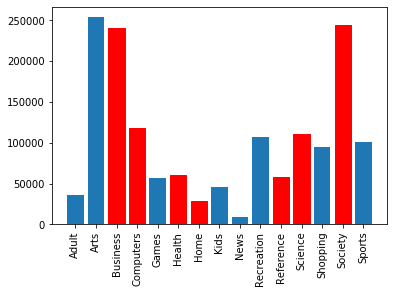

In [7]:
cnt = Counter(url_df['category'])
idx = range(len(cnt))
barlist = plt.bar(idx, cnt.values()) #legend: red (work), blue (play)
barlist[2].set_color('r'); barlist[3].set_color('r'); barlist[5].set_color('r'); barlist[6].set_color('r')
barlist[10].set_color('r'); barlist[11].set_color('r'); barlist[13].set_color('r')
plt.xticks(idx, cnt.keys(), rotation=90)

In [8]:
#text pre-processing
MAX_NB_WORDS = 1e6
tokenizer_nltk = RegexpTokenizer(r'[a-zA-Z]+')
stop_words = set(stopwords.words('english'))
stop_words.update(['http', 'https', 'www', 'com', 'html', 'org', 'ru', 'jp', 'uk', 'ca', '//'])
#stemmer = SnowballStemmer('english')

In [9]:
url_df['url_tokens'] = url_df['url'].apply(lambda x: tokenizer_nltk.tokenize(x))
url_df['url_tokens_filtered'] = url_df['url_tokens'].apply(lambda sent: [word for word in sent if word not in stop_words])
url_df.tail()

,index,url,category,url_tokens,url_tokens_filtered
1562973,1562974,http://www.maxpreps.com/,Sports,"[http, www, maxpreps, com]",[maxpreps]
1562974,1562975,http://www.myscore.com/,Sports,"[http, www, myscore, com]",[myscore]
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports,"[http, sportsillustrated, cnn, com, highschool]","[sportsillustrated, cnn, highschool]"
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports,"[http, rss, cnn, com, rss, si, highschool, for...","[rss, cnn, rss, si, highschool, format, xml]"
1562977,1562978,http://www.usatoday.com/sports/preps/,Sports,"[http, www, usatoday, com, sports, preps]","[usatoday, sports, preps]"


In [10]:
url_df.loc[1562976, 'url']

'http://rss.cnn.com/rss/si_highschool?format=xml'

Let's define a mapping between URL categories and work / play label:

In [11]:
label_df = pd.DataFrame({'category_name': list(cnt.keys()), 
                         'workplay_name':  ['p','p','w','w','p','w','w','p','p','p','w','w','p','w','p'],
                         'workplay_label': ['0','0','1','1','0','1','1','0','0','0','1','1','0','1','0'],
                        })
label_df.head(15)

,category_name,workplay_name,workplay_label
0,Adult,p,0
1,Arts,p,0
2,Business,w,1
3,Computers,w,1
4,Games,p,0
5,Health,w,1
6,Home,w,1
7,Kids,p,0
8,News,p,0
9,Recreation,p,0


In [12]:
label_map_url = {'Adult': 0, 'Arts': 0, 'Business': 1, 'Computers': 1, 'Games': 0, 'Health': 1,
                 'Home': 1, 'Kids': 0, 'News': 0, 'Recreation': 0, 'Reference': 1, 'Science': 1,
                 'Shopping': 0, 'Society': 1, 'Sports': 0}

In [13]:
url_df['target'] = url_df['category'].map(label_map_url)
url_df.tail()

,index,url,category,url_tokens,url_tokens_filtered,target
1562973,1562974,http://www.maxpreps.com/,Sports,"[http, www, maxpreps, com]",[maxpreps],0
1562974,1562975,http://www.myscore.com/,Sports,"[http, www, myscore, com]",[myscore],0
1562975,1562976,http://sportsillustrated.cnn.com/highschool,Sports,"[http, sportsillustrated, cnn, com, highschool]","[sportsillustrated, cnn, highschool]",0
1562976,1562977,http://rss.cnn.com/rss/si_highschool?format=xml,Sports,"[http, rss, cnn, com, rss, si, highschool, for...","[rss, cnn, rss, si, highschool, format, xml]",0
1562977,1562978,http://www.usatoday.com/sports/preps/,Sports,"[http, www, usatoday, com, sports, preps]","[usatoday, sports, preps]",0


In [14]:
num_train = 100000 #int(0.8*len(dataset['target']))  #should match num_train of App dataset!
url_train_df = url_df.sample(n=num_train, random_state=1)
#url_test_df = url_df.sample(n=num_train, random_state=1)
raw_docs_train = url_train_df['url_tokens_filtered']
#raw_docs_test = url_test_df['url_tokens_filtered']
label_train = url_train_df['target'].values
#label_test = url_test_df['target'].values
num_labels = len(np.unique(label_train))
print("{} training examples, {} test examples and {} unique labels".format(num_train, len(url_train_df['target'])-num_train, num_labels))

100000 training examples, 0 test examples and 2 unique labels


In [15]:
print("pre-processing train docs...")
processed_docs_train = []

for doc in raw_docs_train:
    tokens = tokenizer_nltk.tokenize(" ".join(doc))
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

pre-processing train docs...


In [16]:
print("pre-processing test docs...")
processed_docs_test = []

#for doc in raw_docs_test:
#    tokens = tokenizer.tokenize(doc)
#    filtered = [word for word in tokens if word not in stop_words]
#    processed_docs_test.append(" ".join(filtered))

pre-processing test docs...


In [17]:
print("tokenizing input data...")
tokenizer_keras = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer_keras.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer_keras.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer_keras.texts_to_sequences(processed_docs_test)
word_index = tokenizer_keras.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
dictionary size:  104051


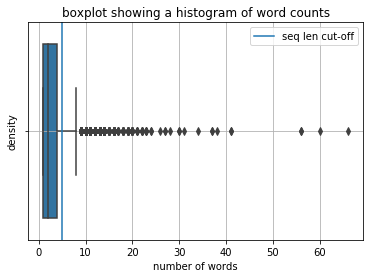

In [18]:
word_id_len = [len(item.split(" ")) for item in processed_docs_train]
max_seq_len = np.round((np.mean(word_id_len) + np.std(word_id_len))).astype(int)
sns.boxplot(word_id_len); plt.axvline(x=max_seq_len, label='seq len cut-off');
plt.title("boxplot showing a histogram of word counts"); plt.xlabel('number of words'); plt.ylabel('density');
plt.grid(True); plt.legend();

In [19]:
#pad sequences
print("padding sequences with max seq len {} words ".format(max_seq_len))
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
#word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
y_url = label_train
#y_test_enc = label_test_mapped

padding sequences with max seq len 5 words 


In [20]:
word_seq_train.shape

(100000, 5)

In [21]:
len(y_url)

100000

Let's start by exploring the App dataset

In [22]:
app_df = pd.read_csv("./data/Data_AppInteractivitySampleRate02.csv")
app_df.dropna(inplace=True)
app_df.columns = ['DeviceId', 'IndustrySegment', 'DeviceSampleRate', 'IsCommercial', 'AppName']
app_df.head()

,DeviceId,IndustrySegment,DeviceSampleRate,IsCommercial,AppName
0,g:6755399441213943,Consumer,0.0,False,4DF9E0F8.NETFLIX_MCM4NJQHNHSS8
1,g:6755399441213943,Consumer,0.0,False,APPLICATIONCLIPSERVICE.EXE
2,g:6755399441213943,Consumer,0.0,False,BA3D8596-3946-4095-ADCE-6D76E101746F_ZJR0DFHGJ...
3,g:6755399441213943,Consumer,0.0,False,BLACKDESERT_QT5FDT83CBZYC
4,g:6755399441213943,Consumer,0.0,False,CSRSS.EXE


We can downsample the original dataset (TODO: look at balanced downsampling) and pre-process the data:

In [23]:
num_train = 100000 #should match num_train of URL dataset
app_df = app_df.sample(n=num_train, random_state=1)
app_df.shape

(100000, 5)

In [24]:
app_df['app'] = app_df['AppName'].apply(lambda x: x.lower()) #convert all app names to lower case
app_df['target'] = app_df['IsCommercial'].apply(lambda x: 1 if x else 0)
app_df.drop(['DeviceId', 'IndustrySegment', 'DeviceSampleRate', 'AppName', 'IsCommercial'], axis=1, inplace=True)
app_df.head(10)

,app,target
7383818,dwm.exe,0
3697897,microsoft.microsoftedge_8wekyb3d8bbwe,0
7394901,excel.exe,1
161400,csrss.exe,0
9148080,explorer.exe,0
3043673,fortnite_d5xxtpggmzx6p,0
6042008,navplugin.exe,0
440165,inputapp_cw5n1h2txyewy,1
4669612,microsoft.windowscalculator_8wekyb3d8bbwe,0
4306322,microsoft.windows.cortana_cw5n1h2txyewy,1


In [25]:
app_df['app'] = app_df['app'].apply(lambda x: x.split('_')[0])  #remove anything after underscore, e.g. microsoft.microsoftedge_8wekyb3d8bbwe
app_df['app'] = app_df['app'].apply(lambda x: x.split('.')[-1] + '.exe' if ('exe' not in x.split('.')) else x) #keep what remains after the last period + '.exe', e.g. microsoftedge.exe
app_df.head(10)

,app,target
7383818,dwm.exe,0
3697897,microsoftedge.exe,0
7394901,excel.exe,1
161400,csrss.exe,0
9148080,explorer.exe,0
3043673,fortnite.exe,0
6042008,navplugin.exe,0
440165,inputapp.exe,1
4669612,windowscalculator.exe,0
4306322,cortana.exe,1


In [26]:
cnt_app = Counter(app_df['app'])
idx_app = range(len(cnt_app))
cnt_app.most_common(20)

[('csrss.exe', 5028),
 ('explorer.exe', 4180),
 ('cortana.exe', 4056),
 ('shellexperiencehost.exe', 3908),
 ('logonui.exe', 3880),
 ('applicationframehost.exe', 3133),
 ('lockapp.exe', 2752),
 ('chrome.exe', 2385),
 ('microsoftedge.exe', 2174),
 ('taskhostw.exe', 2169),
 ('svchost.exe', 1792),
 ('dwm.exe', 1774),
 ('dashboard.exe', 1757),
 ('xam.exe', 1754),
 ('guide.exe', 1724),
 ('xboxui.exe', 1722),
 ('windowsstore.exe', 1504),
 ('winword.exe', 1185),
 ('immersivecontrolpanel.exe', 1154),
 ('idlescreen.exe', 1151)]

Let's look at the level of ambiguity between the Apps, i.e. at an intersection between work and play Apps:

In [27]:
app_work_df = app_df[app_df['target'] == True]
app_play_df = app_df[app_df['target'] == False]
app_intersection = set.intersection(set(app_work_df['app'].values), set(app_play_df['app'].values))
print("number of apps labeled both work and play: ", len(app_intersection))
print(np.random.choice(list(app_intersection), 10))

number of apps labeled both work and play:  1355
['connect.exe' 'acmon.exe' 'powershell.exe' 'inetmgr.exe'
 'vonage business.exe' 'skype.exe' 'pdfplus.exe' 'x2jobtzv.exe'
 '2345safetray.exe' 'megafileupdate.exe']


In [28]:
y_app = app_df['target'].values #binary target variable should match the target variable for URL dataset!
enc = OneHotEncoder(handle_unknown='ignore', sparse=True)
enc.fit(app_df['app'].values.reshape(-1,1))
X1_train = enc.transform(app_df['app'].values.reshape(-1,1))
num_features1 = X1_train.shape[1]
X1_train.shape

(100000, 6705)

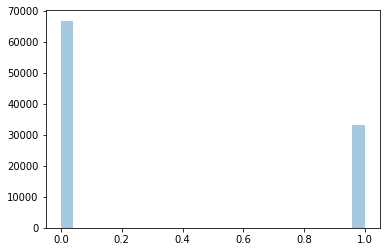

In [29]:
sns.distplot(y_app, kde=False)

Next, let's define our multi-modal NN using the functional keras API

In [31]:
#training params
batch_size = 512
num_epochs = 16

In [32]:
#model parameters
hidden_size_lstm = 32
embed_dim = 300
lstm_dropout = 0.2
dense_dropout = 0.2
weight_decay = 1e-4

In [33]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: ', len(words_not_found))

preparing embedding matrix...
number of null word embeddings:  83470


In [34]:
embedding_matrix.shape

(104052, 300)

In [35]:
print("sample words not found in the embeddings:\n", np.random.choice(words_not_found, 20))

sample words not found in the embeddings:
 ['nonserviam' 'valeriegillespie' 'enticedesign' 'oslm' 'gomog'
 'fmtisystems' 'militaresgay' 'deadworld' 'meishunfang' 'byzantinebooks'
 'kaser' 'kirkley' 'greentea' 'inwap' 'myfitbanner' 'bioimagingsystems'
 'berkhan' 'hometheater' 'sexhosters' 'principlepractice']


In [36]:
#multi-modal NN

#MLP branch
input1 = Input(shape=(num_features1,), name='app')
x = Dense(num_features1, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(input1)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(x)

#LSTM branch
input2 = Input(shape=(max_seq_len,), name='url')
y = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False)(input2)
y = Bidirectional(LSTM(hidden_size_lstm, dropout=lstm_dropout, recurrent_dropout=lstm_dropout))(y)

merged = concatenate([x, y], axis=-1)
z = Dropout(dense_dropout)(merged)
z = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))(z)
output = Dense(1, activation='sigmoid')(z)

model=Model([input1, input2], output)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

W0807 12:30:56.108741 12336 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 12:30:56.137742 12336 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 12:30:56.142743 12336 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 12:30:56.202759 12336 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras\backend\tensorfl

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                (None, 6705)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6705)         44963730    app[0][0]                        
__________________________________________________________________________________________________
url (InputLayer)                (None, 5)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          858368      dense_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [37]:
#define callbacks
SAVE_PATH = "./data/"
file_name = SAVE_PATH + 'dnn-weights-checkpoint-v2.h5'
checkpoint = ModelCheckpoint(file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=16, verbose=1)
callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping]

Define the training label to be an OR between App label and the URL label to bias the training data towards work:

In [38]:
y_train = y_url | y_app

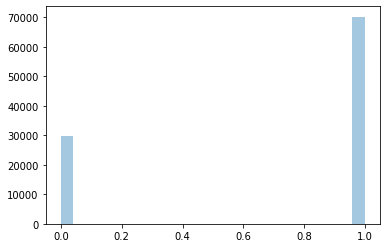

In [39]:
sns.distplot(y_train, kde=False)

In [40]:
hist = model.fit({'app': X1_train, 'url': word_seq_train}, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Train on 90000 samples, validate on 10000 samples
Epoch 1/16
 - 172s - loss: 0.6305 - acc: 0.7084 - val_loss: 0.5855 - val_acc: 0.7107

Epoch 00001: val_loss improved from inf to 0.58554, saving model to ./data/dnn-weights-checkpoint-v2.h5
Epoch 2/16
 - 166s - loss: 0.5740 - acc: 0.7232 - val_loss: 0.5761 - val_acc: 0.7167

Epoch 00002: val_loss improved from 0.58554 to 0.57608, saving model to ./data/dnn-weights-checkpoint-v2.h5
Epoch 3/16
 - 165s - loss: 0.5666 - acc: 0.7275 - val_loss: 0.5697 - val_acc: 0.7171

Epoch 00003: val_loss improved from 0.57608 to 0.56970, saving model to ./data/dnn-weights-checkpoint-v2.h5
Epoch 4/16
 - 175s - loss: 0.5574 - acc: 0.7305 - val_loss: 0.5660 - val_acc: 0.7198

Epoch 00004: val_loss improved from 0.56970 to 0.56603, saving model to ./data/dnn-weights-checkpoint-v2.h5
Epoch 5/16
 - 168s - loss: 0.5533 - acc: 0.7323 - val_loss: 0.5653 - val_acc: 0.7204

Epoch 00005: val_loss improved from 0.56603 to 0.56529, saving model to ./data/dnn-weights-c

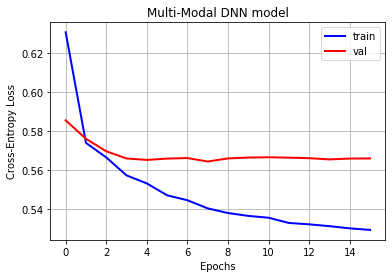

In [41]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], c='b', lw=2.0, label='train')
plt.plot(hist.history['val_loss'], c='r', lw=2.0, label='val')
plt.title('Multi-Modal DNN model')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('./figures/dnn_loss.png')

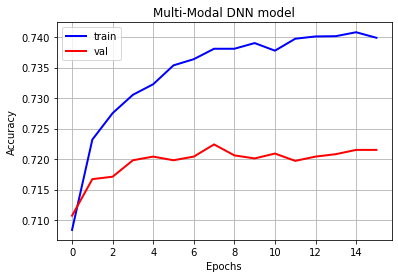

In [42]:
plt.figure()
plt.plot(hist.history['acc'], c='b', lw=2.0, label='train')
plt.plot(hist.history['val_acc'], c='r', lw=2.0, label='val')
plt.title('Multi-Modal DNN model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('./figures/dnn_acc.png')

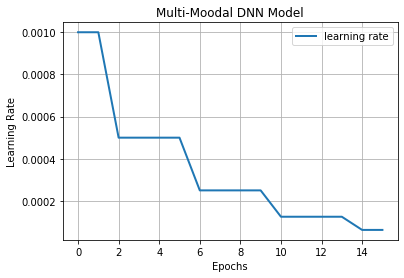

In [43]:
plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('Multi-Moodal DNN Model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.savefig('./figures/dnn_learning_rate.png')

In [ ]:
#plot_model(model, show_shapes=True, to_file='./figures/dnn_model.png')

Let's load the trained model and predict on user test session data next:

In [44]:
dnn_model = load_model('./data/dnn-weights-checkpoint-v2.h5')
dnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
app (InputLayer)                (None, 6705)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6705)         44963730    app[0][0]                        
__________________________________________________________________________________________________
url (InputLayer)                (None, 5)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          858368      dense_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [45]:
print("loading and pre-processing App test data...")
app_test_df = pd.read_csv('./data/AppResult.csv', sep=',')
app_test_df['target'] = app_test_df['Label'].map({'work': 1, 'play': 0})
y_app_test = app_test_df['target'].values

#use the one-hot encoder fit on all apps to transform existing test apps
X1_test = enc.transform(app_test_df['Process'].values.reshape(-1,1)) 
X1_test.shape

loading and pre-processing App test data...


(1604, 6705)

In [47]:
print("loading and pre-processing URL test data...")
url_test_df = pd.read_csv("./data/URLResult.csv")
url_test_df.columns = ['index', 'url', 'category']
url_test_df.dropna(inplace=True)

url_test_df['url_tokens'] = url_test_df['url'].apply(lambda x: tokenizer_nltk.tokenize(x))
url_test_df['url_tokens_filtered'] = url_test_df['url_tokens'].apply(lambda sent: [word for word in sent if word not in stop_words])
url_test_df['target'] = url_test_df['category'].map({'work': 1, 'play': 0})

num_train = X1_test.shape[0]  #to match input lengths
url_test_df = url_test_df.sample(n=num_train, replace=True, random_state=1)
raw_docs_test = url_test_df['url_tokens_filtered']
y_url_test = url_test_df['target'].values

processed_docs_test = []
for doc in raw_docs_test:
    tokens = tokenizer_nltk.tokenize(" ".join(doc))
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

word_seq_test = tokenizer_keras.texts_to_sequences(processed_docs_test)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
word_seq_test.shape


loading and pre-processing URL test data...


(1604, 5)

In [48]:
y_label_test = y_url_test | y_app_test

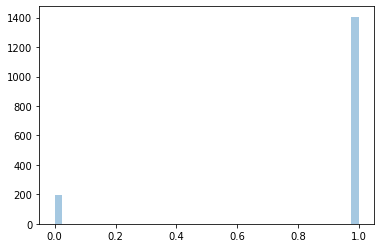

In [50]:
sns.distplot(y_label_test, kde=False)

Let's evaluate the model on test data next:

In [56]:
score_prob = dnn_model.predict({'app': X1_test, 'url': word_seq_test}, batch_size=32, verbose=1)
score_threshold = 0.6
score_final = list(map(lambda x: 1 if x > score_threshold else 0, score_prob))

1604/1604 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 857us/step


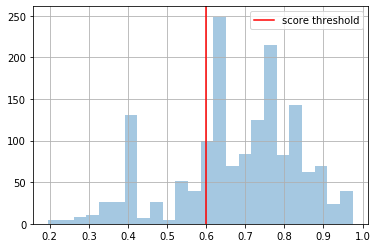

In [58]:
sns.distplot(score_prob, kde=False)
plt.axvline(x=score_threshold, c='r', label='score threshold'); plt.grid(True); plt.legend()

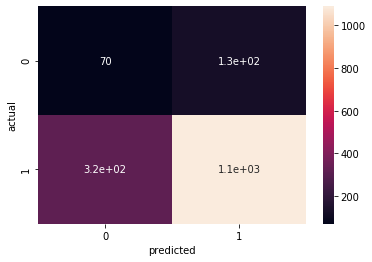

In [59]:
score_data = {'y_pred': score_final, 'y_true': y_label_test}

score_df = pd.DataFrame(score_data, columns=['y_true','y_pred'])
confusion_matrix = pd.crosstab(score_df['y_true'], score_df['y_pred'], rownames=['actual'], colnames=['predicted'])

sns.heatmap(confusion_matrix, annot=True)

In [60]:
clf_acc = np.trace(confusion_matrix.values)/sum(sum(confusion_matrix.values))
print("classification accuracy: ", clf_acc)

classification accuracy:  0.722568578553616


Let's export the model into ONNX format

In [61]:
output_onnx_model = './data/model-v2.onnx'

# Convert the Keras model into ONNX
onnx_model = onnxmltools.convert_keras(dnn_model)

# Save as protobuf
onnxmltools.utils.save_model(onnx_model, output_onnx_model)

W0807 13:30:30.835594 12336 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras2onnx\common\utils.py:42: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0807 13:30:30.835594 12336 deprecation_wrapper.py:119] From C:\Users\t-vasmol.REDMOND\AppData\Local\Continuum\anaconda3\envs\vss\lib\site-packages\keras2onnx\common\utils.py:42: The name tf.logging.WARN is deprecated. Please use tf.compat.v1.logging.WARN instead.



### References

[1] Francois Chollet, "Deep Learning with Python", 2017 